In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import pandas as pd
#from lr_utils import load_dataset
#from public_tests import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
import keras_tuner as kt

In [2]:
def load_dataset():
    with h5py.File('datasets/train_catvnoncat.h5', "r") as train_dataset:
        train_set_x_orig = np.array(train_dataset["train_set_x"][:])
        train_set_y_orig = np.array(train_dataset["train_set_y"][:])

    with h5py.File('datasets/test_catvnoncat.h5', "r") as test_dataset:
        test_set_x_orig = np.array(test_dataset["test_set_x"][:])
        test_set_y_orig = np.array(test_dataset["test_set_y"][:])
        classes = np.array(test_dataset["list_classes"][:])

    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))

    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes


In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

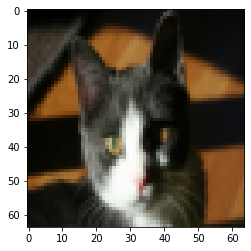

In [4]:
# example of a picture
index = 19
plt.imshow(train_set_x_orig[index])

In [5]:
train_set_y = train_set_y.flatten()
test_set_y = test_set_y.flatten()

In [6]:
# normalization layer
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(64, 64, 3)),
    normalization_layer,
    tf.keras.layers.Dense(1, activation='sigmoid',)
])

In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = False),
              metrics=['accuracy'])

In [9]:
history = model.fit(train_set_x_orig, train_set_y, epochs=100, verbose=False)

In [10]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,epoch
95,0.124995,0.990431,95
96,0.120032,0.990431,96
97,0.125841,0.995215,97
98,0.129152,0.985646,98
99,0.120240,0.980861,99


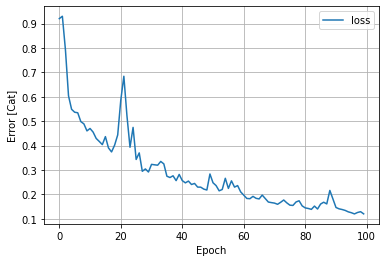

In [11]:
# plotting loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error [Cat]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [12]:
test_loss, test_acc = model.evaluate(test_set_x_orig, test_set_y, verbose=2)
print('\nTest accuracy:', test_acc)

2/2 - 0s - loss: 0.7492 - accuracy: 0.7400

Test accuracy: 0.7400000095367432


In [16]:
predict = model.predict(test_set_x_orig)

predict = (predict > 0.5).astype(int).ravel()
print(predict)

[1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 0 1 1 1 1 0 0
 1 0 0 1 1 1 0 1 1 0 1 1 0]


In [14]:
def model_builder(hp):
    model = Sequential()
    model.add(layers.Flatten(input_shape=(64, 64, 3)))
    model.add(normalization_layer)
    
    # Tune units in Dense layer from 32 to 512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    # Tune steps in regularizer
    model.add(Dense(units=hp_units, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    model.add(Dense(1, activation='sigmoid'))
    
    # Tune the learning rate for the optimizer from 0.1 to 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits = False),
                  metrics=['accuracy'])

    return model

In [15]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='CatClassifier',
                     project_name='TFCatClassifier')